# Problem
The new test for solving pde using pytorch:

$
\frac{\partial{u}}{\partial t} = \kappa (\frac{\partial^2 u}{\partial{x}^2}+\frac{\partial^2 u}{\partial{y}^2}) + S(x,y,t)
$

in the square region $0 \le x \le 2$ and $ 0 \le y \le 2$
for the time $0 \le t \le 2$

Independent variables:
* t - time
* x - coordinate
* y - coordinate

Dependent variables output:
* u - diffusion species

In [2]:
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np

In [4]:
# rewrite in layer, this is rather boilplate code 
class DiffNet(nn.Module):
    def __init__(self, input_size,hidden_size,
                output_size, depth, act=torch.nn.Tanh):
        super(DiffNet, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' %i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' %i,act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))
        
        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)
    
    def forward(self, X):
        out = self.layers(X)
        return out

## New layer architecture (Giulio)


In [5]:
class ComplexHeatEquationNet(torch.nn.Module):
    def __init__(self):
        super(ComplexHeatEquationNet, self).__init__()
        self.fc1 = torch.nn.Linear(3, 512)
        self.ln1 = torch.nn.LayerNorm(512)
        self.silu1 = torch.nn.SiLU()
        self.fc2 = torch.nn.Linear(512, 256)
        self.ln2 = torch.nn.LayerNorm(256)
        self.silu2 = torch.nn.SiLU()
        self.fc3 = torch.nn.Linear(256, 128)
        self.ln3 = torch.nn.LayerNorm(128)
        self.silu3 = torch.nn.SiLU()
        self.fc4 = torch.nn.Linear(128, 64)
        self.ln4 = torch.nn.LayerNorm(64)
        self.silu4 = torch.nn.SiLU()
        self.fc5 = torch.nn.Linear(64, 32)
        self.ln5 = torch.nn.LayerNorm(32)
        self.silu5 = torch.nn.SiLU()
        self.fc6 = torch.nn.Linear(32, 1)

    def forward(self, X):
        x = self.silu1(self.ln1(self.fc1(X)))
        x = self.silu2(self.ln2(self.fc2(x)))
        x = self.silu3(self.ln3(self.fc3(x)))
        x = self.silu4(self.ln4(self.fc4(x)))
        x = self.silu5(self.ln5(self.fc5(x)))
        x = self.fc6(x)
        return x

Material properties for this case:

In [6]:
ρ = 7860; Cp = 624; k = 30.1
γ = 2.5e+4; P = 1e+2; r0 = 0.05; y_min=0.0; y_max = 0.1; x_min = 0.0; x_max = 0.1;
κ = k/(ρ * Cp)
T0 = 300.0

Differential model for this equation is very similar as for one-dimensional case.
* predict out based on the coordinates $x, y$ and time $t$.

In [7]:
learn_rate = 0.01
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        # build model
        # self.model = DiffNet(
        #        input_size=3,
        #        hidden_size=128,
        #        output_size=1,
        #        depth=5,
        #        act=torch.nn.Tanh).to(device)
        self.model = ComplexHeatEquationNet().to(device)
        # Initial and boundary conditions, we first create the 
        # meshgrid for x and y coordinates. The mesh is regular 
        # grid with h and k steps.
        self.h = 0.005
        self.k = 0.005
        self.dt = 0.005
        
        x = torch.arange(0, 0.1 + self.h, self.h)
        y = torch.arange(0, 0.1 + self.k, self.k)
        t = torch.arange(0, 0.1 + self.dt, self.dt)
        
        
        xmin_bc = torch.stack(torch.meshgrid(x[0],y,t)).reshape(3,-1).T
        xmax_bc = torch.stack(torch.meshgrid(x[-1],y,t)).reshape(3,-1).T
        ymin_bc = torch.stack(torch.meshgrid(x,y[0],t)).reshape(3,-1).T
        ymax_bc = torch.stack(torch.meshgrid(x,y[-1],t)).reshape(3,-1).T
        
        ic = torch.stack(torch.meshgrid(x,y,t[0])).reshape(3,-1).T
        
        # make training bcs
        # self.bc_train = torch.cat([ic, xmin_bc, xmax_bc, ymin_bc, ymax_bc]) @ivt note this are all boundary conditions
        self.bc_train = torch.cat([ic, xmin_bc, xmax_bc, ymin_bc])
        self.bc_train = self.bc_train.to(device)
        
        self.X = torch.stack(torch.meshgrid(x,y,t)).reshape(3,-1).T.to(device)
        self.X.requires_grad = True
        
        self.all_zeros = torch.zeros_like(self.X).to(device)
        self.all_zeros.requires_grad = False
        
        #initial and boundary condition 
        u_init = torch.zeros(len(ic))
        u_xmin = torch.ones(len(xmin_bc))*T0
        u_xmax = torch.ones(len(xmax_bc))*T0
        u_ymin = torch.ones(len(ymax_bc))*T0
        u_ymax = torch.ones(len(ymin_bc))*T0
        
        # self.u_train = torch.cat([u_init, u_xmin, u_xmax, u_ymin, u_ymax])
        self.u_train = torch.cat([u_init, u_xmin, u_xmax, u_ymin])
        self.u_train = self.u_train.unsqueeze(1)
        self.u_train = self.u_train.to(device)
        
        self.mse_cost_function = nn.MSELoss()
        self.optimizer = torch.optim.LBFGS(self.model.parameters(),lr=learn_rate,max_iter=500,max_eval=50000,
                                  history_size=50,tolerance_grad=1e-5,tolerance_change=1.0 * np.finfo(float).eps)
        self.optimizer_Adam = torch.optim.Adam(self.model.parameters())
        self.iter = 0
        
    def source(self): 
        return 2*P/(torch.pi*r0**2)*torch.exp(-2/(r0**2)*((self.X[:,0]-self.X[:,2]*0.02)**2 + (self.X[:,1]-y_max/2)**2))

    def f(self):
        u = self.model(self.X) 
             
        u_dX = torch.autograd.grad(
            u, self.X, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = u_dX[:,0]
        u_y = u_dX[:,1]
        u_t = u_dX[:,2]
        
       
        
        u_dXX = torch.autograd.grad(
            u_dX, self.X, 
            grad_outputs=torch.ones_like(u_dX),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = u_dXX[:,0]
        u_yy = u_dXX[:,1]
        
        return u_t - κ*u_xx - κ*u_yy - self.source()
    
    def loss_func(self):
        self.optimizer.zero_grad()
    
        # initial and boundary conditions
        out = self.model(self.bc_train)
        mse_u = self.mse_cost_function(out, self.u_train)
        
        # fix condition for PDE
        out = self.f()
        mse_f = self.mse_cost_function(out, torch.zeros_like(out))
    
        #loss = mse_u + mse_u_xmax + mse_u_xmin + mse_u_ymax + mse_u_ymin + mse_f
        loss = mse_f + mse_u
        loss.backward()
        
        if self.iter % 100 == 0:
            print(f" Iter: {self.iter}, loss:{loss.data}")
            
        self.iter += 1
        return loss
        
    def train(self,epochs):
        for epoch in range(epochs):
            self.optimizer_Adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

In [8]:
net = Net()
net.train(10000)

C:\Users\ivt\Anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


 Iter: 0, loss:66706052.0
 Iter: 100, loss:65971980.0
 Iter: 200, loss:66338412.0
 Iter: 300, loss:66641420.0
 Iter: 400, loss:64576768.0
 Iter: 500, loss:63330208.0
 Iter: 600, loss:61750324.0
 Iter: 700, loss:60105516.0
 Iter: 800, loss:58363464.0
 Iter: 900, loss:56367112.0
 Iter: 1000, loss:54296144.0
 Iter: 1100, loss:52183320.0
 Iter: 1200, loss:50163832.0
 Iter: 1300, loss:48021212.0
 Iter: 1400, loss:45464812.0
 Iter: 1500, loss:43102316.0
 Iter: 1600, loss:40588280.0
 Iter: 1700, loss:38534404.0
 Iter: 1800, loss:36241928.0
 Iter: 1900, loss:34787780.0
 Iter: 2000, loss:32068688.0
 Iter: 2100, loss:30094200.0
 Iter: 2200, loss:28437560.0
 Iter: 2300, loss:27218046.0
 Iter: 2400, loss:24824032.0
 Iter: 2500, loss:23065502.0
 Iter: 2600, loss:22272438.0
 Iter: 2700, loss:21342476.0
 Iter: 2800, loss:18912518.0
 Iter: 2900, loss:16790514.0
 Iter: 3000, loss:19141344.0
 Iter: 3100, loss:16745629.0
 Iter: 3200, loss:13556239.0
 Iter: 3300, loss:12247447.0
 Iter: 3400, loss:11964810

In [17]:
net.train(10000)

 Iter: 30800, loss:71318.859375
 Iter: 30900, loss:71719.0234375
 Iter: 31000, loss:72573.453125
 Iter: 31100, loss:71246.171875
 Iter: 31200, loss:84703.25
 Iter: 31300, loss:71200.0859375
 Iter: 31400, loss:96580.5625
 Iter: 31500, loss:71140.171875
 Iter: 31600, loss:71163.21875
 Iter: 31700, loss:71088.1640625
 Iter: 31800, loss:71128.3359375
 Iter: 31900, loss:71047.296875
 Iter: 32000, loss:73563.2265625
 Iter: 32100, loss:71007.578125
 Iter: 32200, loss:70977.1484375
 Iter: 32300, loss:70973.34375
 Iter: 32400, loss:71622.8515625
 Iter: 32500, loss:70988.40625
 Iter: 32600, loss:70888.4296875
 Iter: 32700, loss:70947.75
 Iter: 32800, loss:70863.4296875
 Iter: 32900, loss:71405.1875
 Iter: 33000, loss:83799.75
 Iter: 33100, loss:70786.078125
 Iter: 33200, loss:72979.171875
 Iter: 33300, loss:89182.59375
 Iter: 33400, loss:70716.1328125
 Iter: 33500, loss:70754.5546875
 Iter: 33600, loss:73119.2734375
 Iter: 33700, loss:72836.0078125
 Iter: 33800, loss:81507.484375
 Iter: 33900, l

In [109]:
torch.arange(0,0.1,0.01)

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900])

shape: (21, 21, 21)


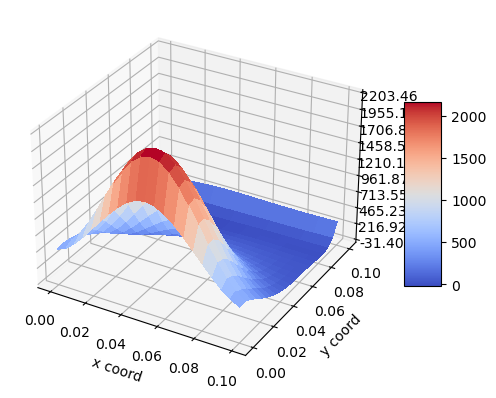

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = plt.axes(projection='3d')
dx = 0.005
x = torch.arange(0,0.1+dx,dx)
y = torch.arange(0,0.1+dx,dx)
t = torch.ones_like(x)*0.1
X = torch.stack(torch.meshgrid(x,y,t)).reshape(3,-1).T.to(device)


u_pred = net.model(X)
um = u_pred.data.cpu().numpy()
um = um.reshape(21,21,21)

x = np.arange(0,0.1+dx,dx)
y = np.arange(0,0.1+dx,dx)
xm, ym = np.meshgrid(x,y)

print(f"shape: {um.shape}")

surf = ax.plot_surface(xm, ym, um[:,:,3], cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel("y coord")
ax.set_xlabel("x coord")
fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()

In [151]:
def solution(x,y,t):
    return np.exp(x + y) * np.cos(x + y + 4*t)
anal_sol = solution(x,y,2)
mse=np.mean((anal_sol-u_pred.data.cpu().numpy())**2)


TypeError: mean() received an invalid combination of arguments - got (axis=NoneType, dtype=NoneType, out=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [18]:
mse

1.7507350066943392

In [176]:
x.shape[0]

21

In [178]:
u_pred.shape

torch.Size([9261, 1])